In [1]:
from prody import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import fnmatch
from os.path import basename

### A script that calculates RMSD, RMSF, cross-correlation and PCA on an MD trajectory as a batch calculation

#### Warning: Your pdb and dcd files should have the same filename.
#### Outputs will have prefixes based on your pdb filename

@> 855 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> DCD file contains 201 coordinate sets for 855 atoms.
@> DCD file was parsed in 0.00 seconds.
@> 1.98 MB parsed at input rate 659.63 MB/s.
@> 201 coordinate sets parsed at input rate 66893 frame/s.
@> Superposing  [ 42%] 1s

1pga.pdb
Ensemble 1pga (0:201:1)


@> Superposition completed in 0.35 seconds.


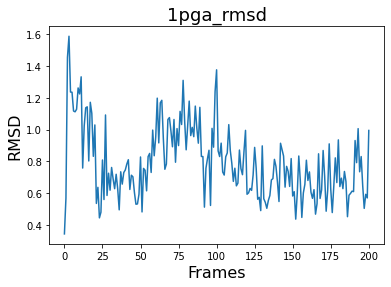

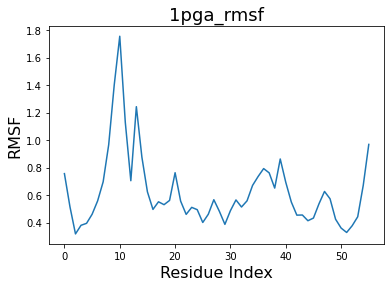

@> Covariance is calculated using 201 coordinate sets.
@> Covariance matrix calculated in 0.175608s.


56


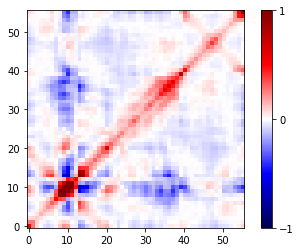

@> 162 modes were calculated in 0.00s.


In [2]:
for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*.pdb'):
        # find the pdb file, parse it, select calphas and parse DCD file on it
        pdb_name = file
        print(pdb_name)
        structure = parsePDB(str(pdb_name))
        file_name_wh_ex = str(os.path.splitext(pdb_name)[0])
        # you can use other atom selections for example for cbeta and calpha for glycines:
        # "(name CB and protein) or (name CA and resname GLY)"
        structure_calpha = structure.select("calpha")
        residue_number = len(structure_calpha)
        ensemble_cov = parseDCD(str(file_name_wh_ex)+".dcd")
        # you can assign start, stop and stride like this
        # ensemble_cov = parseDCD(str(file_name_wh_ex)+".dcd", 0, 201, 1)
        print(ensemble_cov)
        

        ensemble_cov.setAtoms(structure_calpha)
        ensemble_cov.setCoords(structure)
        ensemble_cov.superpose()
        
        
        #First calculate RMSD, save it to a file and plot it
        rmsd = ensemble_cov.getRMSDs()
        np.savetxt(file_name_wh_ex+"_rmsd.dat",rmsd)

        plt.plot(range(len(rmsd)), rmsd)
        plt.title(file_name_wh_ex+"_rmsd", fontsize=18)
        plt.xlabel('Frames', fontsize=16)
        plt.ylabel('RMSD', fontsize=16)
        plt.savefig(file_name_wh_ex+"_rmsd.png",dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        # Then calculate RMSF, again save and plot.
        rmsf = ensemble_cov.getRMSFs()
        np.savetxt(file_name_wh_ex+"_rmsf.dat",rmsf)

        plt.plot(range(len(rmsf)), rmsf)
        plt.title(file_name_wh_ex+"_rmsf", fontsize=18)
        plt.xlabel('Residue Index', fontsize=16)
        plt.ylabel('RMSF', fontsize=16)
        plt.savefig(file_name_wh_ex+"_rmsf.png",dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()


        #calculate covariance and cross-correlation matrices
        eda_ensemble = EDA('')
        eda_ensemble.buildCovariance(ensemble_cov)
        covariance = eda_ensemble.getCovariance()


        cross_corr = np.zeros((residue_number,residue_number))
        for i in range(residue_number):
            for j in range(residue_number):
                a = (3*(i))
                b = (3*(i)+1)
                c = (3*(i)+2)
                d = (3*(j))
                e = (3*(j)+1)
                f = (3*(j)+2)
                cross_corr[i,j] = covariance[a,d]+covariance[b,e]+covariance[c,f]

        corr = cross_corr
        print(len(corr))
        file_name_wh_ex = str(os.path.splitext(file)[0])
        fig, ax = plt.subplots()
        #Plot and save cross-corr matrix
        arange = np.arange(residue_number)
        cax = plt.imshow(corr, vmin=-1, vmax=1, cmap=cm.seismic, origin="lower")
        cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
        plt.savefig(str(file_name_wh_ex)+"_correlation", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        #calculate modes and eigenvalue contributions as percentage
        eda_ensemble.calcModes(100000)
        eigvals_sum = np.sum(eda_ensemble.getEigvals())
        eigvals_contri_list = []

        for i in range(10):
            eigvals_contri = (eda_ensemble[i].getEigval()/ np.sum(eda_ensemble.getEigvals()))*100
            eigvals_contri_list.append(eigvals_contri)

        np.savetxt(file_name_wh_ex+"_eigvals_contribution.dat",eigvals_contri_list)
        
        with open(file_name_wh_ex+"_eigvals_sum.dat", 'w') as f:
            f.write('%s\t%s\n' % (file_name_wh_ex, eigvals_sum))
            f.close()
            
        #Write an NMD file which you can use 'normal mode wizard' in VMD to plot modes
        writeNMD(file_name_wh_ex+"_pca.nmd", eda_ensemble, structure_calpha)
